Negative Samples: 984, Positive Samples: 800, Min Samples: 800
Negative Samples: 246, Positive Samples: 200, Min Samples: 200
使用设备: cuda
Epoch [1/100], Train Loss: 1.881345, Val Loss: 1.107431
Epoch [2/100], Train Loss: 1.311033, Val Loss: 1.084181
Epoch [3/100], Train Loss: 1.256744, Val Loss: 1.064481
Epoch [4/100], Train Loss: 1.222369, Val Loss: 1.145416
Epoch [5/100], Train Loss: 1.199988, Val Loss: 1.075800
Epoch [6/100], Train Loss: 1.180366, Val Loss: 1.129375
Epoch [7/100], Train Loss: 1.168958, Val Loss: 1.142713
Epoch [8/100], Train Loss: 1.162629, Val Loss: 1.101129
Epoch [9/100], Train Loss: 1.147819, Val Loss: 1.081495
Epoch [10/100], Train Loss: 1.143983, Val Loss: 1.147706
Epoch [11/100], Train Loss: 1.135367, Val Loss: 1.073137
Epoch [12/100], Train Loss: 1.125837, Val Loss: 1.117552
Epoch [13/100], Train Loss: 1.125377, Val Loss: 1.150719
Epoch [14/100], Train Loss: 1.115618, Val Loss: 1.114318
Epoch [15/100], Train Loss: 1.110727, Val Loss: 1.145699
Epoch [16/100], T

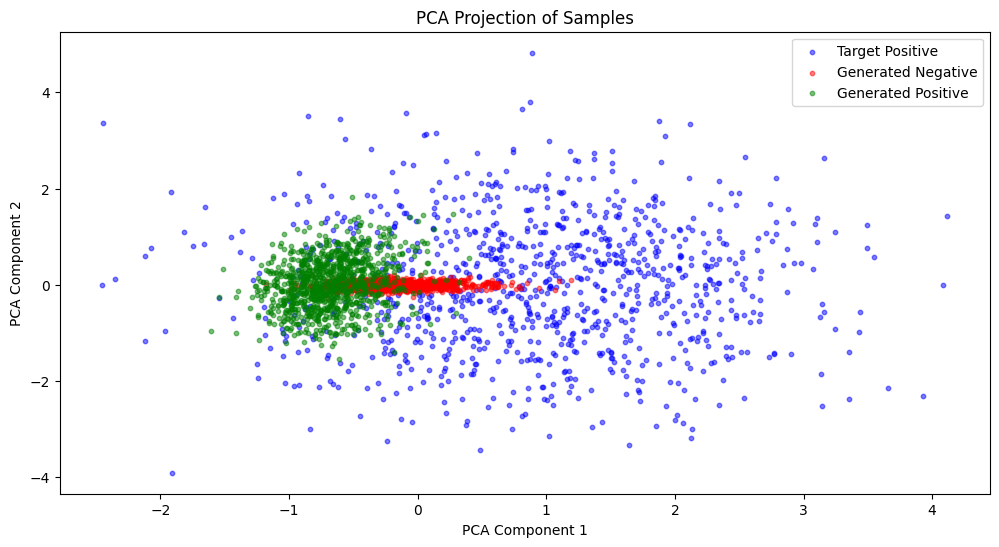

/home/ckqsudo/miniconda3/envs/py11/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


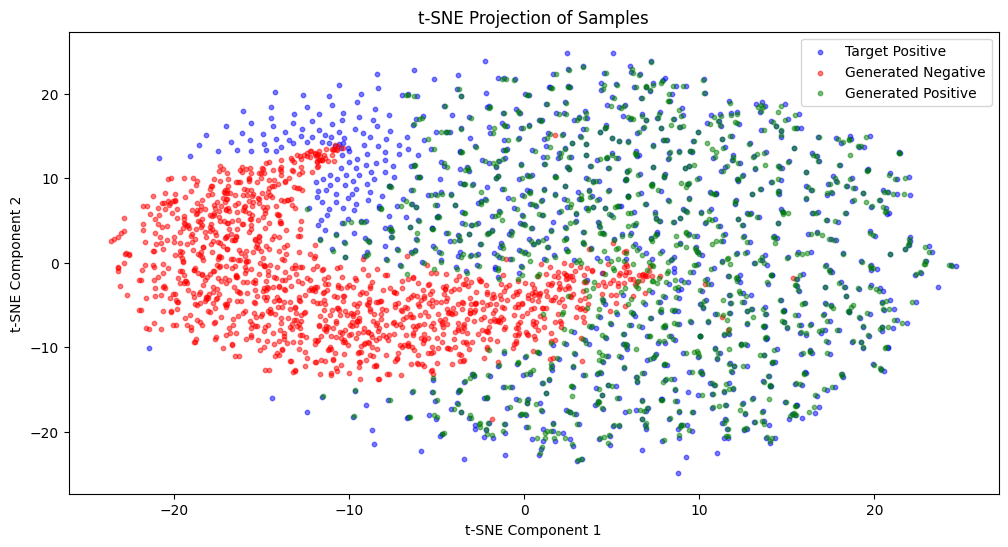


Generated Samples from Inference:
[[1.9452426 1.9501287 1.8438337 ... 1.9620018 1.9085531 1.9561999]
 [1.8732097 1.8706375 1.8190572 ... 1.8447016 1.8929538 1.9079989]
 [1.977788  1.9905971 1.9150729 ... 1.9973158 1.903224  2.0112007]
 ...
 [1.951635  1.9422208 1.8228556 ... 1.8764789 1.8550831 1.9020325]
 [1.86846   1.945655  1.851093  ... 1.9469234 1.9358017 1.9160155]
 [1.8341253 1.9192492 1.9118388 ... 1.8290988 1.8416045 1.9201657]]


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# 设置自动求导异常检测（可选）
torch.autograd.set_detect_anomaly(True)

# 定义MLP模型
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# 数据准备
def prepare_data(num_neg=1230, num_pos=1000, input_dim=128):
    """
    生成负样本和正样本，并合并到一起。
    
    参数：
    - num_neg: 负样本数量
    - num_pos: 正样本数量
    - input_dim: 特征维度
    
    返回：
    - data: 合并后的数据张量，形状 [num_neg + num_pos, input_dim]
    - labels: 合并后的标签张量，形状 [num_neg + num_pos]
    """
    # 设置不同的均值
    negative_mean = 0.0
    positive_mean = 2.0  # 正样本均值偏移为2.0，使其与负样本分布明显不同
    
    # 生成负样本和正样本
    negative_samples = np.random.randn(num_neg, input_dim) + negative_mean
    positive_samples = np.random.randn(num_pos, input_dim) + positive_mean
    
    # 转换为PyTorch张量
    negative_samples = torch.from_numpy(negative_samples).float()
    positive_samples = torch.from_numpy(positive_samples).float()
    
    # 创建标签
    negative_labels = torch.zeros(num_neg)  # 标签为0
    positive_labels = torch.ones(num_pos)   # 标签为1
    
    # 合并数据和标签
    data = torch.cat([negative_samples, positive_samples], dim=0)
    labels = torch.cat([negative_labels, positive_labels], dim=0)
    
    return data, labels

# 创建平衡的 DataLoader（下采样）
def create_balanced_dataloader(data, labels, batch_size=32, seed=42):
    """
    创建一个平衡的 DataLoader，确保每个批次中正负样本数量一致。
    
    参数：
    - data: 数据张量，形状 [num_samples, input_dim]
    - labels: 标签张量，形状 [num_samples]
    - batch_size: 每个批次的样本数量
    - seed: 随机种子
    
    返回：
    - dataloader: PyTorch DataLoader 对象
    """
    # 分离正负样本索引
    neg_indices = (labels == 0).nonzero(as_tuple=True)[0]
    pos_indices = (labels == 1).nonzero(as_tuple=True)[0]
    
    # 确定最小样本数量
    min_samples = min(len(neg_indices), len(pos_indices))
    print(f"Negative Samples: {len(neg_indices)}, Positive Samples: {len(pos_indices)}, Min Samples: {min_samples}")
    
    # 设置随机种子以确保可重复性
    torch.manual_seed(seed)
    
    # 随机选择样本
    neg_selected = neg_indices[torch.randperm(len(neg_indices))[:min_samples]]
    pos_selected = pos_indices[torch.randperm(len(pos_indices))[:min_samples]]
    
    # 合并平衡后的索引
    balanced_indices = torch.cat([neg_selected, pos_selected], dim=0)
    
    # 创建平衡后的数据集
    balanced_dataset = Subset(TensorDataset(data, labels), balanced_indices)
    
    # 创建 DataLoader
    dataloader = DataLoader(balanced_dataset, batch_size=batch_size, shuffle=True)
    
    return dataloader

# 定义综合L1损失函数
def combined_l1_loss(generated, target, labels, l1_criterion):
    """
    计算综合L1损失：
    - 对于正样本（label=1）：output 应尽可能接近 input（保持不变）。
    - 对于负样本（label=0）：output 应尽可能接近正样本的均值向量（转换为正样本）。
    
    参数：
    - generated: 模型生成的输出，形状 [batch_size, input_dim]
    - target: 输入数据，形状 [batch_size, input_dim]
    - labels: 样本标签，形状 [batch_size]
    - l1_criterion: L1损失函数
    
    返回：
    - loss: 综合L1损失
    """
    # 分离正负样本
    pos_mask = labels == 1
    neg_mask = labels == 0
    
    loss = 0.0
    
    if pos_mask.sum() > 0:
        # 对于正样本：output 应接近 input
        loss_pos = l1_criterion(generated[pos_mask], target[pos_mask])
        loss += loss_pos
    
    if neg_mask.sum() > 0:
        # 对于负样本：output 应接近正样本的均值向量
        # 计算正样本的均值
        pos_mean = target[pos_mask].mean(dim=0, keepdim=True)  # [1, input_dim]
        # 将均值向量扩展到与负样本相同的形状
        pos_mean_expanded = pos_mean.expand_as(generated[neg_mask])
        loss_neg = l1_criterion(generated[neg_mask], pos_mean_expanded)
        loss += loss_neg
    
    return loss

# 推理函数
def inference(model, input_data, device):
    """
    对输入数据进行推理，生成输出。
    
    参数：
    - model: 训练好的模型
    - input_data: NumPy数组，形状 [num_samples, input_dim]
    - device: 设备（CPU或GPU）
    
    返回：
    - 生成的输出，NumPy数组，形状 [num_samples, output_dim]
    """
    model.eval()
    with torch.no_grad():
        input_tensor = torch.from_numpy(input_data).float().to(device)
        generated_output = model(input_tensor)
    return generated_output.cpu().numpy()

# 可视化样本分布（PCA）
def visualize_distributions(target_positive, generated_neg, generated_pos):
    """
    使用PCA将高维数据降维到2维，并绘制分布图。
    
    参数：
    - target_positive: 目标正样本，NumPy数组，形状 [num_pos, input_dim]
    - generated_neg: 生成的负样本，NumPy数组，形状 [num_neg, input_dim]
    - generated_pos: 生成的正样本，NumPy数组，形状 [num_pos, input_dim]
    """
    pca = PCA(n_components=2)
    # 结合所有数据进行PCA
    combined = np.vstack((target_positive, generated_neg, generated_pos))
    pca.fit(combined)
    
    target_positive_pca = pca.transform(target_positive)
    generated_neg_pca = pca.transform(generated_neg)
    generated_pos_pca = pca.transform(generated_pos)
    
    plt.figure(figsize=(12, 6))
    
    # 绘制正样本
    plt.scatter(target_positive_pca[:, 0], target_positive_pca[:, 1], 
                c='blue', label='Target Positive', alpha=0.5, s=10)
    
    # 绘制生成的负样本
    plt.scatter(generated_neg_pca[:, 0], generated_neg_pca[:, 1], 
                c='red', label='Generated Negative', alpha=0.5, s=10)
    
    # 绘制生成的正样本
    plt.scatter(generated_pos_pca[:, 0], generated_pos_pca[:, 1], 
                c='green', label='Generated Positive', alpha=0.5, s=10)
    
    plt.legend()
    plt.title('PCA Projection of Samples')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.show()

# 可视化样本分布（t-SNE）
def visualize_distributions_tsne(target_positive, generated_neg, generated_pos):
    """
    使用t-SNE将高维数据降维到2维，并绘制分布图。
    
    参数：
    - target_positive: 目标正样本，NumPy数组，形状 [num_pos, input_dim]
    - generated_neg: 生成的负样本，NumPy数组，形状 [num_neg, input_dim]
    - generated_pos: 生成的正样本，NumPy数组，形状 [num_pos, input_dim]
    """
    tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
    # 结合所有数据进行t-SNE
    combined = np.vstack((target_positive, generated_neg, generated_pos))
    tsne_results = tsne.fit_transform(combined)
    
    # 划分降维后的数据
    target_positive_tsne = tsne_results[:len(target_positive)]
    generated_neg_tsne = tsne_results[len(target_positive):len(target_positive)+len(generated_neg)]
    generated_pos_tsne = tsne_results[len(target_positive)+len(generated_neg):]
    
    plt.figure(figsize=(12, 6))
    
    # 绘制正样本
    plt.scatter(target_positive_tsne[:, 0], target_positive_tsne[:, 1], 
                c='blue', label='Target Positive', alpha=0.5, s=10)
    
    # 绘制生成的负样本
    plt.scatter(generated_neg_tsne[:, 0], generated_neg_tsne[:, 1], 
                c='red', label='Generated Negative', alpha=0.5, s=10)
    
    # 绘制生成的正样本
    plt.scatter(generated_pos_tsne[:, 0], generated_pos_tsne[:, 1], 
                c='green', label='Generated Positive', alpha=0.5, s=10)
    
    plt.legend()
    plt.title('t-SNE Projection of Samples')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.show()

# 计算均值和协方差差异
def compute_mean_covariance(tensor1, tensor2):
    """
    计算两个张量的均值向量差异和协方差矩阵差异。
    
    参数：
    - tensor1: 张量1，形状 [num_samples1, dim]
    - tensor2: 张量2，形状 [num_samples2, dim]
    
    返回：
    - mean_diff: 欧氏距离
    - cov_diff: 弗罗贝尼乌斯范数
    """
    mean1 = torch.mean(tensor1, dim=0)
    mean2 = torch.mean(tensor2, dim=0)
    cov1 = torch.cov(tensor1.T)
    cov2 = torch.cov(tensor2.T)
    mean_diff = torch.norm(mean1 - mean2, p=2).item()
    cov_diff = torch.norm(cov1 - cov2, p='fro').item()
    return mean_diff, cov_diff

# 打印部分样本值
def print_sample_values(generated_neg, generated_pos, all_positive, num_samples=5):
    """
    打印生成的负样本和正样本与目标正样本的部分值。
    
    参数：
    - generated_neg: 生成的负样本，张量，形状 [num_neg, input_dim]
    - generated_pos: 生成的正样本，张量，形状 [num_pos, input_dim]
    - all_positive: 目标正样本，张量，形状 [num_pos, input_dim]
    - num_samples: 要打印的样本数量
    """
    print(f"\nSample Generated Negative Samples vs Target Positive Samples:")
    for i in range(num_samples):
        print(f"Sample {i+1}:")
        print(f"Generated Negative: {generated_neg[i].cpu().numpy()[:5]}...")
        print(f"Target Positive:    {all_positive[i].cpu().numpy()[:5]}...\n")
    
    print(f"Sample Generated Positive Samples vs Target Positive Samples:")
    for i in range(num_samples):
        print(f"Sample {i+1}:")
        print(f"Generated Positive: {generated_pos[i].cpu().numpy()[:5]}...")
        print(f"Target Positive:    {all_positive[i].cpu().numpy()[:5]}...\n")

# 主函数
def main():
    # 准备数据
    data, labels = prepare_data(num_neg=1230, num_pos=1000, input_dim=128)
    
    # 划分训练集和验证集
    # 80%训练，20%验证
    train_ratio = 0.8
    num_samples = data.size(0)
    indices = torch.randperm(num_samples)
    train_size = int(train_ratio * num_samples)
    train_indices = indices[:train_size]
    val_indices = indices[train_size:]
    
    train_data = data[train_indices]
    train_labels = labels[train_indices]
    val_data = data[val_indices]
    val_labels = labels[val_indices]
    
    # 创建平衡的 DataLoader（下采样）
    train_loader = create_balanced_dataloader(train_data, train_labels, batch_size=32, seed=42)
    val_loader = create_balanced_dataloader(val_data, val_labels, batch_size=32, seed=24)
    
    # 检查设备
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"使用设备: {device}")
    
    # 模型参数
    input_dim = 128
    hidden_dim = 256
    output_dim = 128
    
    # 初始化模型并移动到设备
    model = MLP(input_dim, hidden_dim, output_dim).to(device)
    
    # 优化器
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # 学习率调度器
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
    
    # 定义L1损失函数
    l1_criterion = nn.L1Loss()
    
    num_epochs = 100
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        
        for batch_data, batch_labels in train_loader:
            batch_data = batch_data.to(device)
            batch_labels = batch_labels.to(device)
            
            optimizer.zero_grad()
            generated = model(batch_data)
            
            # 计算综合L1损失
            loss = combined_l1_loss(generated, batch_data, batch_labels, l1_criterion)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * batch_data.size(0)
        train_loss /= len(train_loader.dataset)
        
        # 验证
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_data, batch_labels in val_loader:
                batch_data = batch_data.to(device)
                batch_labels = batch_labels.to(device)
                
                generated = model(batch_data)
                
                # 计算综合L1损失
                loss = combined_l1_loss(generated, batch_data, batch_labels, l1_criterion)
                val_loss += loss.item() * batch_data.size(0)
            val_loss /= len(val_loader.dataset)
        
        # 打印epoch统计
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')
        
        # 更新学习率
        scheduler.step()
    
    # 保存模型（可选）
    torch.save(model.state_dict(), 'mlp_model.pth')
    
    # 计算最终的综合L1损失
    model.eval()
    with torch.no_grad():
        generated = model(data.to(device))
        final_loss = combined_l1_loss(generated, data.to(device), labels.to(device), l1_criterion)
    print(f'Final Combined L1 Loss: {final_loss.item():.6f}')
    
    # 计算并打印统计量
    with torch.no_grad():
        generated = model(data.to(device))
        pos_mask = labels == 1
        neg_mask = labels == 0
        generated_neg = generated[neg_mask]
        generated_pos = generated[pos_mask]
        target_pos = data[pos_mask].to(device)
        
        mean_diff_neg, cov_diff_neg = compute_mean_covariance(generated_neg, target_pos)
        mean_diff_pos, cov_diff_pos = compute_mean_covariance(generated_pos, target_pos)
        
    print("\nMean and Covariance Differences:")
    print(f"Generated Negative vs Target Positive - Mean Diff: {mean_diff_neg:.6f}, Cov Diff: {cov_diff_neg:.6f}")
    print(f"Generated Positive vs Target Positive - Mean Diff: {mean_diff_pos:.6f}, Cov Diff: {cov_diff_pos:.6f}")
    
    # 打印部分样本值
    print_sample_values(generated_neg, generated_pos, target_pos, num_samples=5)
    
    # 可视化样本分布（使用PCA）
    visualize_distributions(target_pos.cpu().numpy(), generated_neg.cpu().numpy(), generated_pos.cpu().numpy())
    
    # 可视化样本分布（使用t-SNE）
    visualize_distributions_tsne(target_pos.cpu().numpy(), generated_neg.cpu().numpy(), generated_pos.cpu().numpy())
    
    # 推理阶段示例
    # 假设有新的负样本数据
    new_negative_samples = np.random.randn(10, 128) + 0.0  # 生成10个新的负样本
    generated_samples = inference(model, new_negative_samples, device)
    print("\nGenerated Samples from Inference:")
    print(generated_samples)

if __name__ == "__main__":
    main()
